**Proceso de selección para el cargo de analista en la Coordinación de Analítica de ProColombia**

# Empresas con alto potencial de atención: Vicepresidencia de Exportaciones

## Autor

Nicolás Rivera Garzón, nicolas.riveragr@gmail.com

## Contenido
* [1. Objetivo](#Objetivo)
* [2. Metodología](#Metodología)
* [3. Exploración de datos](#Exploración_de_datos)
* [4. Algoritmo K-Medias](#Algoritmo_K_Medias)

## 1. Objetivo <a name="Objetivo"></a> 

Identificar las empresas que tienen un alto potencial de atención en ProColombia con alta probabilidad de convertirse en exportadoras

## 2. Metodología <a name="Metodología"></a> 

Se realizará el siguiente proceso: 
1. Importación de datos desde un directorio que se puede cambiar fácilmente para replicar datos.
2. Análisis exploratorio de datos para encontrar puntos relevantes y características de la base de datos.
3. Construcción del modelo K-medias para encontrar los clientes con potencial a ser atendidos por Procolombia.
4. Exportación de la información de los clientes a formato Excel. 

## 3. Exploración de datos <a name="Exploración_de_datos"></a>

In [1]:
# Cambiar el directorio de trabajo al lugar donde estén los datos
import os

# Nuevo directorio
data_directory = 'C:\\Users\\Nicolás Rivera\\OneDrive\\Escritorio\\Procolombia\\Datos'
os.chdir(data_directory)

# El sigueinte es el directorio donde se realiza la prueba
os.getcwd() 

'C:\\Users\\Nicolás Rivera\\OneDrive\\Escritorio\\Procolombia\\Datos'

In [2]:
## Cargue de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm as notebook_tqdm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Localizar el codo de K means (pip install kneed)
from kneed import KneeLocator

## Param
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# Importar datos
exportaciones = pd.read_csv('Exportaciones.txt', sep='|', decimal=',', encoding='utf-8')
dane = pd.read_csv('Directorio_DANE.txt', sep='|', decimal=',', encoding='utf-8')
super_sociedades = pd.read_csv('Supersociedades.txt', sep='|', decimal=',', encoding='utf-8')
rues = pd.read_csv('RUES.txt', sep='|', decimal=',', encoding='utf-8')

# Agregar una columna Fuente a cada DataFrame
exportaciones['Fuente'] = 'Exportaciones'
dane['Fuente'] = 'Directorio DANE'
super_sociedades['Fuente'] = 'Super Sociedades'
rues['Fuente'] = 'RUES'

C:\Users\Nicolás Rivera\AppData\Local\Temp\ipykernel_12472\851905697.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  rues = pd.read_csv('RUES.txt', sep='|', decimal=',', encoding='utf-8')


In [4]:
# Crear una sola base de datos
df = pd.concat([exportaciones, dane, super_sociedades, rues], ignore_index=True)

In [5]:
# Hay 80050 clientes duplicados, se deben eliminar solo para tener clientes únicos
df = df.drop_duplicates(subset='NIT', keep='first')

In [6]:
# ¿Hay nits nulos?
df['NIT'].isnull().any()

False

In [7]:
# Nulos en las demás columnas
# Verificar valores nulos en todas las columnas y calcular el porcentaje
nulos_por_columna = df.isnull().sum()
porcentaje_nulos_por_columna = (nulos_por_columna / len(df)) * 100

# Crear un DataFrame para mostrar los resultados
info_nulos = pd.DataFrame({
    'Columna': nulos_por_columna.index,
    'Valores Nulos': nulos_por_columna.values,
    'Porcentaje de Nulos': porcentaje_nulos_por_columna.values
})

# Mostrar el resultado ordenado por el porcentaje de nulos de mayor a menor
info_nulos = info_nulos.sort_values(by='Porcentaje de Nulos', ascending=False)
print("Información sobre valores nulos por columna:")
print(info_nulos)

Información sobre valores nulos por columna:
                            Columna  Valores Nulos  Porcentaje de Nulos
26                   Var. Expo 2022          48959                97.92
27             TCAC expo ult 5 años          48843                97.69
25             Expo prom ult 5 años          46727                93.45
24                        Expo 2022          46727                93.45
14               Antigüedad empresa           8335                16.67
9                           Activos           8296                16.59
0                               NIT              0                 0.00
17              Sector* ult 10 años              0                 0.00
29              Cadena segmentación              0                 0.00
28                 Trayectoria expo              0                 0.00
23           Expo Latam ult 10 años              0                 0.00
22        Departamento* ult 10 años              0                 0.00
21   Cod. Departame

Los valores se incorporan en el análisis ya que no se deben imputar porque no hay otra fuente confiable. Además cuando una empresa tiene variables relacioandas con exportaciones vacias signfica que no tiene un gran potencial exportador. 

In [8]:
df.columns

Index(['NIT', 'Cod. Depto', 'Departamento', 'Cod. Municipio', 'Municipio',
       'CIIU Rev 4 principal', 'Descripción CIIU principal',
       'Cadena CIIU principal', 'Valor agregado empresa', 'Activos',
       'Ingresos operacionales', 'Tamaño empresa RUES',
       'Sucursal sociedad extranjera', 'País domicilio casa matriz',
       'Antigüedad empresa', 'Tipo* ult 10 años', 'Cadena* ult 10 años',
       'Sector* ult 10 años', 'Subsector* ult 10 años', 'Posara* ult 10 años',
       'Descripcion posara* ult 10 años', 'Cod. Departamento* ult 10 años',
       'Departamento* ult 10 años', 'Expo Latam ult 10 años', 'Expo 2022',
       'Expo prom ult 5 años', 'Var. Expo 2022', 'TCAC expo ult 5 años',
       'Trayectoria expo', 'Cadena segmentación', 'Fuente'],
      dtype='object')

In [9]:
# Valores únicos por columna
valores_unicos_por_columna = df.nunique()

# Mostrar los valores únicos por columna
print("Valores únicos por columna:")
print(valores_unicos_por_columna)

Valores únicos por columna:
NIT                                50000
Cod. Depto                            63
Departamento                          34
Cod. Municipio                      1067
Municipio                            861
CIIU Rev 4 principal                 536
Descripción CIIU principal           298
Cadena CIIU principal                 12
Valor agregado empresa                11
Activos                            22996
Ingresos operacionales             20756
Tamaño empresa RUES                    5
Sucursal sociedad extranjera           3
País domicilio casa matriz            12
Antigüedad empresa                  7174
Tipo* ult 10 años                      3
Cadena* ult 10 años                    8
Sector* ult 10 años                   56
Subsector* ult 10 años               199
Posara* ult 10 años                 1211
Descripcion posara* ult 10 años     1210
Cod. Departamento* ult 10 años        28
Departamento* ult 10 años             28
Expo Latam ult 10 años       

In [10]:
# Estadísticas descriptivas
stats_descriptivas = df.describe()
print(stats_descriptivas)

           NIT          Activos  Ingresos operacionales  Antigüedad empresa  \
count 50000.00         41704.00                50000.00            41665.00   
mean  24999.50    2930534340.67           2740929174.35                7.50   
std   14433.90   39008897978.74          65661919360.04                8.08   
min       0.00             0.00                   -1.00                0.00   
25%   12499.75       6000000.00                    0.00                2.20   
50%   24999.50      36351760.00              1000000.00                5.12   
75%   37499.25     349787140.75            268271743.25                9.65   
max   49999.00 3447215000000.00       12589678554000.00               74.87   

         Expo 2022  Expo prom ult 5 años  Var. Expo 2022  TCAC expo ult 5 años  
count      3273.00               3273.00         1041.00               1157.00  
mean     904319.51             700759.01          230.42                -37.63  
std     9315071.88            6795130.26     

In [11]:
# Estadísticas descriptivas por trayectoria export
# Lista de columnas a considerar
columnas_a_considerar = ['Activos', 'Ingresos operacionales', 'Antigüedad empresa', 'Expo 2022', 'Expo prom ult 5 años', 'Var. Expo 2022', 'TCAC expo ult 5 años']

# Convertir las columnas seleccionadas a números
df[columnas_a_considerar] = df[columnas_a_considerar].apply(pd.to_numeric, errors='coerce')

# Filtrar observaciones mayores a 0 en todas las columnas numéricas
df_filtrado_positivos = df[(df[columnas_a_considerar] > 0).all(axis=1)]

# Estadísticas descriptivas por Trayectoria expo
stats_descriptivas_por_trayectoria_expo = df_filtrado_positivos.groupby('Trayectoria expo')[columnas_a_considerar].agg(['count', 'mean', 'min', 'max'])

# Mostrar las estadísticas descriptivas agrupadas por Trayectoria expo
print(stats_descriptivas_por_trayectoria_expo)

                         Activos                                 \
                           count            mean            min   
Trayectoria expo                                                  
Mineras, chatarra, otros       2  23321067500.00 12358224000.00   
No Constante                  22  15041910722.14    26869432.00   
Pymex                        173  39916787083.54    10500000.00   
Top                           38 271535772763.16 12261582000.00   

                                          Ingresos operacionales  \
                                      max                  count   
Trayectoria expo                                                   
Mineras, chatarra, otros   34283911000.00                      2   
No Constante               56405715000.00                     22   
Pymex                     679847697000.00                    173   
Top                      1283131574000.00                     38   

                                                     

In [12]:
# Estadísticas descriptivas por exportación a latam en los últimos 10 años
# Lista de columnas a considerar
columnas_a_considerar = ['Activos', 'Ingresos operacionales', 'Antigüedad empresa', 'Expo 2022', 'Expo prom ult 5 años', 'Var. Expo 2022', 'TCAC expo ult 5 años']

# Convertir las columnas seleccionadas a números
df[columnas_a_considerar] = df[columnas_a_considerar].apply(pd.to_numeric, errors='coerce')

# Filtrar observaciones mayores a 0 en todas las columnas numéricas
df_filtrado_positivos = df[(df[columnas_a_considerar] > 0).all(axis=1)]

# Estadísticas descriptivas por Trayectoria expo
stats_descriptivas_por_expolatam = df_filtrado_positivos.groupby('Expo Latam ult 10 años')[columnas_a_considerar].agg(['count', 'mean', 'min', 'max'])

# Mostrar las estadísticas descriptivas agrupadas por Trayectoria expo
print(stats_descriptivas_por_expolatam)

                       Activos                                              \
                         count           mean         min              max   
Expo Latam ult 10 años                                                       
No                          14 22377258138.57 10500000.00  222874368000.00   
Si                         221 78227357861.53 15020000.00 1283131574000.00   

                       Ingresos operacionales                              \
                                        count           mean          min   
Expo Latam ult 10 años                                                      
No                                         14 42714528365.14 316590000.00   
Si                                        221 92818566422.50      1000.00   

                                        Antigüedad empresa        ...  \
                                    max              count  mean  ...   
Expo Latam ult 10 años                                            ...   
No  

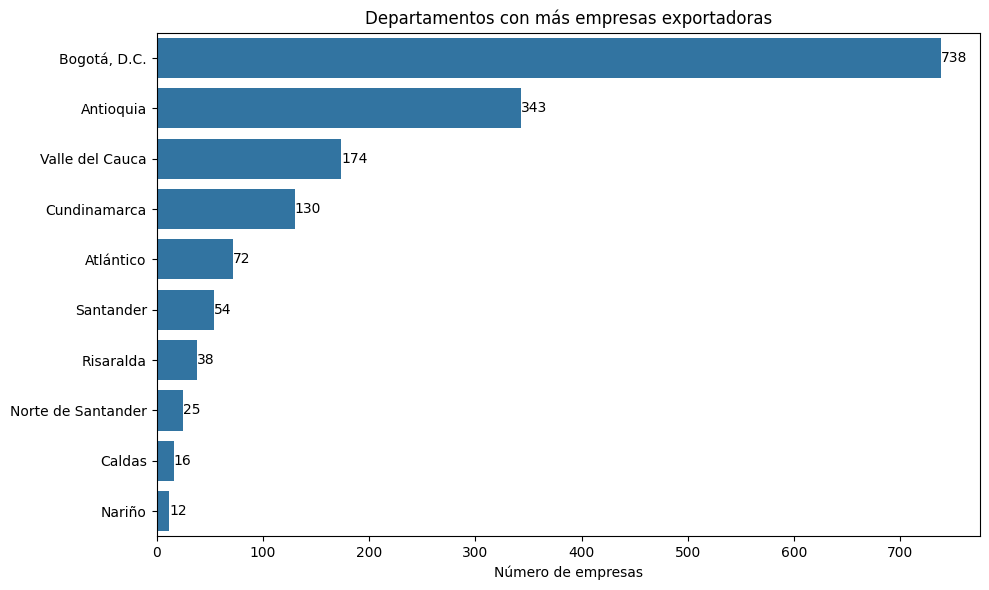

In [13]:
# Número de empresas exportadoras por departamento
# Filtrar los datos para incluir solo aquellos con 'Expo Latam ult 10 años' igual a 'si'
exportaciones_si = df[df['Expo Latam ult 10 años'] == 'Si']

# Filtrar los datos para excluir el departamento 'No determinado'
exportaciones_si = exportaciones_si[exportaciones_si['Departamento'] != 'No determinado']

# Contar el número de NIT por departamento
nit_por_departamento = exportaciones_si.groupby('Departamento')['NIT'].nunique()

# Seleccionar los top 5 departamentos
top_departamentos = nit_por_departamento.nlargest(10)

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=top_departamentos.values, y=top_departamentos.index)

# Agregar etiquetas
plt.xlabel('Número de empresas')
plt.ylabel('')
plt.title('Departamentos con más empresas exportadoras')
# Agregar etiquetas de valores sobre las columnas
for index, value in enumerate(top_departamentos):
    bar_plot.text(value, index, str(value), ha='left', va='center')

# Guardar gráfico
# Crear una carpeta llamada 'graficos' si no existe
if not os.path.exists('Resultados'): os.makedirs('Resultados')
plt.tight_layout()
plt.savefig('Resultados\Empresas_por_Dept.png', dpi=300)

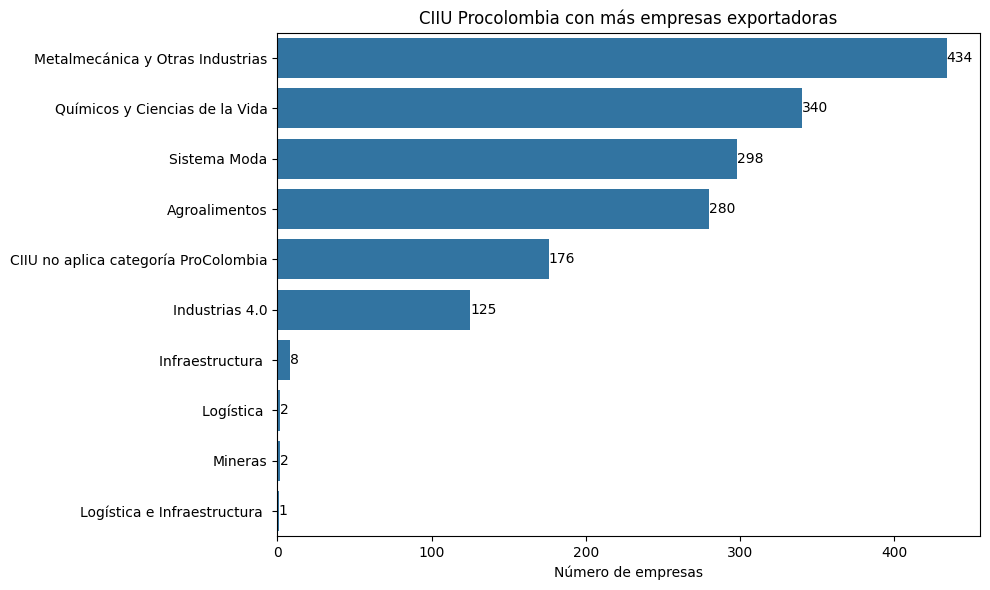

In [14]:
# Número de empresas exportadoras por actividad económica principal
# Filtrar los datos para incluir solo aquellos con 'Expo Latam ult 10 años' igual a 'si'
exportaciones_si = df[df['Expo Latam ult 10 años'] == 'Si']

# Filtrar los datos para excluir la actividad 'No determinado'
exportaciones_si = exportaciones_si[exportaciones_si['Cadena CIIU principal'] != 'No determinado']

# Contar el número de NIT por actividad
nit_por_actividad = exportaciones_si.groupby('Cadena CIIU principal')['NIT'].nunique()

# Seleccionar los top 5 actividades
top_actividad = nit_por_actividad.nlargest(10)

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=top_actividad.values, y=top_actividad.index)

# Agregar etiquetas
plt.xlabel('Número de empresas')
plt.ylabel('')
plt.title('CIIU Procolombia con más empresas exportadoras')
# Agregar etiquetas de valores sobre las columnas
for index, value in enumerate(top_actividad):
    bar_plot.text(value, index, str(value), ha='left', va='center')

# Guardar gráfico
plt.tight_layout()
plt.savefig('Resultados\Empresas_por_actividad.png', dpi=300)

## 4. Algoritmo K-Medias <a name="Algoritmo_K_Medias"></a>

In [15]:
# Valores únicos para variables de segmentación
columnas = ['Cadena segmentación', 'Trayectoria expo', 'Expo Latam ult 10 años', 'Tipo* ult 10 años', 'Cadena CIIU principal']

for columna in columnas:
    valores_unicos = df[columna].unique()
    
    print(f'Valores únicos en la columna "{columna}":\n{valores_unicos}\n')

Valores únicos en la columna "Cadena segmentación":
['Agroalimentos' 'Sistema Moda' 'Químicos y Ciencias de la Vida'
 'Industrias 4.0' 'Metalmecánica y Otras Industrias']

Valores únicos en la columna "Trayectoria expo":
['Futuros' 'No Constante' 'Mineras, chatarra, otros' 'Top' 'Pymex']

Valores únicos en la columna "Expo Latam ult 10 años":
['Si' 'No']

Valores únicos en la columna "Tipo* ult 10 años":
['No Mineras' 'Mineras' 'No exportó ult. 10 años']

Valores únicos en la columna "Cadena CIIU principal":
['No determinado' 'Sistema Moda' 'Químicos y Ciencias de la Vida'
 'Industrias 4.0' 'Agroalimentos' 'CIIU no aplica categoría ProColombia'
 'Metalmecánica y Otras Industrias' 'Infraestructura ' 'Turismo'
 'Logística ' 'Mineras' 'Logística e Infraestructura ']



In [16]:
columnas_para_segmentación = ['NIT','Cadena segmentación', 'Trayectoria expo', 'Expo Latam ult 10 años', 'Tipo* ult 10 años', 'Cadena CIIU principal']
df_seg = df[columnas_para_segmentación].copy()
df_seg.head(10)

,NIT,Cadena segmentación,Trayectoria expo,Expo Latam ult 10 años,Tipo* ult 10 años,Cadena CIIU principal
0,10,Agroalimentos,Futuros,Si,No Mineras,No determinado
1,45,Sistema Moda,Futuros,Si,No Mineras,Sistema Moda
2,56,Sistema Moda,Futuros,No,No Mineras,No determinado
3,60,Químicos y Ciencias de la Vida,Futuros,Si,No Mineras,Químicos y Ciencias de la Vida
4,75,Industrias 4.0,Futuros,No,No Mineras,Industrias 4.0
5,137,Agroalimentos,No Constante,No,No Mineras,Agroalimentos
6,143,Agroalimentos,No Constante,No,No Mineras,Agroalimentos
7,182,Metalmecánica y Otras Industrias,Futuros,Si,No Mineras,CIIU no aplica categoría ProColombia
8,183,Agroalimentos,Futuros,Si,No Mineras,No determinado
9,206,Metalmecánica y Otras Industrias,Futuros,Si,No Mineras,No determinado


In [17]:
df_seg.columns

Index(['NIT', 'Cadena segmentación', 'Trayectoria expo',
       'Expo Latam ult 10 años', 'Tipo* ult 10 años', 'Cadena CIIU principal'],
      dtype='object')

In [18]:
# Eliminar filas con valores nulos si es necesario
df_seg = df_seg.dropna()

# Seleccionar solo las columnas categóricas para la segmentación
columnas_categoricas = df_seg.select_dtypes(include=['object']).columns
df_categorical = df_seg[columnas_categoricas]

# Convertir las columnas categóricas a tipo 'str' si no lo están
df_categorical = df_categorical.astype(str)

# Aplicar codificación one-hot
encoder = OneHotEncoder(sparse=False, drop='first')
df_encoded = encoder.fit_transform(df_categorical)

# Concatenar los datos codificados con las variables originales y eliminar nan
df_final = pd.concat([df_seg, pd.DataFrame(df_encoded, columns=encoder.get_feature_names_out(columnas_categoricas))], axis=1)
df_final = df_final.dropna()

# Seleccionar solo las columnas codificadas para la segmentación
columnas_codificadas = df_final.select_dtypes(include=['float64', 'int64']).columns
df_encoded_only = df_final[columnas_codificadas]

# Normalizar los datos
df_scaled = StandardScaler().fit_transform(df_encoded_only)

C:\ProgramData\Anaconda3\envs\mientorno\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
# Determinar el número óptimo de clusters usando el método del codo
inertia = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)  # Establecer explícitamente n_init
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

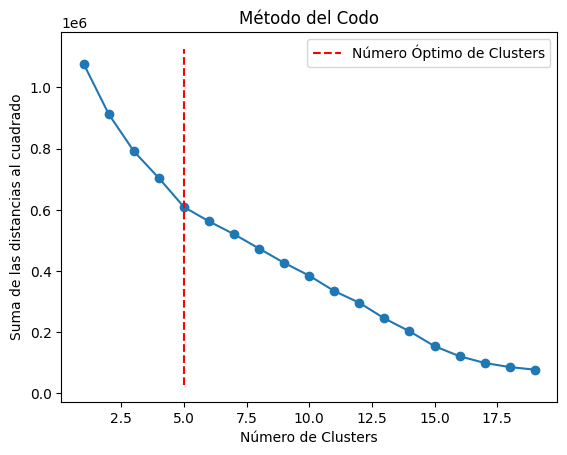

Número óptimo de clústeres: 5


In [20]:
# Encontrar el codo automáticamente
knee_locator = KneeLocator(range(1, 20), inertia, curve='convex', direction='decreasing')
optimal_k = knee_locator.elbow

# Graficar el método del codo con el codo marcado
plt.plot(range(1, 20), inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Suma de las distancias al cuadrado')
plt.title('Método del Codo')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Número Óptimo de Clusters')
plt.legend()
plt.savefig('Resultados\Método_del_codo.png', dpi=300)
plt.show()

# Imprimir el número óptimo de clústeres
print("Número óptimo de clústeres:", optimal_k)

In [21]:
# Elegir el número óptimo de clusters
numero_clusters = 5

# Aplicar K-medias con el número óptimo de clusters
kmeans = KMeans(n_clusters=numero_clusters, random_state=42, n_init=10)
df_final['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualizar los resultados
df_final = df_final[['NIT','Cluster']]

In [22]:
# Crear base de datos final con cluster
df_full = pd.merge(df, df_final[['NIT', 'Cluster']], on='NIT', how='left')

In [23]:
# Base de posibles clientes
df_filtered = df_full[(df_full['Expo Latam ult 10 años'] == 'Si') & (~df_full['Cluster'].isnull())]

In [24]:
df_filtered.head()

,NIT,Cod. Depto,Departamento,Cod. Municipio,Municipio,CIIU Rev 4 principal,Descripción CIIU principal,Cadena CIIU principal,Valor agregado empresa,Activos,...,Departamento* ult 10 años,Expo Latam ult 10 años,Expo 2022,Expo prom ult 5 años,Var. Expo 2022,TCAC expo ult 5 años,Trayectoria expo,Cadena segmentación,Fuente,Cluster
0,10,No determinado,No determinado,No determinado,No determinado,No determinado,No determinado,No determinado,No determinado,NaN,...,Atlántico,Si,0.00,22680.00,NaN,NaN,Futuros,Agroalimentos,Exportaciones,3.00
1,45,5,Antioquia,5001,Medellín,1410,"Confección de prendas de vestir, excepto prend...",Sistema Moda,Bienes tecnología baja,4872620000.00,...,Antioquia,Si,0.00,1214.67,NaN,-100.00,Futuros,Sistema Moda,Exportaciones,3.00
3,60,11,"Bogotá, D.C.",11001,"Bogotá, D.C.",2229,Fabricación de artículos de plástico n.c.p.,Químicos y Ciencias de la Vida,Bienes tecnología media-baja,3500499088.00,...,"Bogotá, D.C.",Si,0.00,0.00,NaN,NaN,Futuros,Químicos y Ciencias de la Vida,Exportaciones,3.00
7,182,11,"Bogotá, D.C.",11001,"Bogotá, D.C.",4659,Comercio al por mayor de otros tipos de maquin...,CIIU no aplica categoría ProColombia,Servicios menos intensivos en conocimiento,23482366000.00,...,"Bogotá, D.C.",Si,0.00,0.00,NaN,NaN,Futuros,Metalmecánica y Otras Industrias,Exportaciones,3.00
8,183,No determinado,No determinado,No determinado,No determinado,No determinado,No determinado,No determinado,No determinado,NaN,...,"Bogotá, D.C.",Si,0.00,0.00,NaN,NaN,Futuros,Agroalimentos,Exportaciones,3.00


In [25]:
# Ver valores únicos de variables de segmentación
columnas = ['Cadena segmentación', 'Trayectoria expo', 'Expo Latam ult 10 años', 'Tipo* ult 10 años', 'Cadena CIIU principal', 'Cluster']

for columna in columnas:
    valores_unicos = df_filtered[columna].unique()
    
    print(f'Valores únicos en la columna "{columna}":\n{valores_unicos}\n')

Valores únicos en la columna "Cadena segmentación":
['Agroalimentos' 'Sistema Moda' 'Químicos y Ciencias de la Vida'
 'Metalmecánica y Otras Industrias' 'Industrias 4.0']

Valores únicos en la columna "Trayectoria expo":
['Futuros' 'No Constante' 'Mineras, chatarra, otros' 'Top' 'Pymex']

Valores únicos en la columna "Expo Latam ult 10 años":
['Si']

Valores únicos en la columna "Tipo* ult 10 años":
['No Mineras' 'Mineras']

Valores únicos en la columna "Cadena CIIU principal":
['No determinado' 'Sistema Moda' 'Químicos y Ciencias de la Vida'
 'CIIU no aplica categoría ProColombia' 'Industrias 4.0'
 'Metalmecánica y Otras Industrias' 'Agroalimentos' 'Infraestructura '
 'Logística ' 'Mineras' 'Logística e Infraestructura ']

Valores únicos en la columna "Cluster":
[3.]



In [26]:
# Exportar resultados a excel
df_filtered.to_excel('Resultados\Clientes Potenciales.xlsx', index=False)